# 1)- Introduction

- The momentum trading strategy consists of creating buying/selling signals based on various time framed sum moving averages (SMA) of an asset's price action or volume (2-days MA, 3-weeks MA, etc..). In general, we follow the momentum of the price action by buying low and selling high.

- Just like the ARIMA notebook, we are going to conduct our data analytics using AAPL stock over this year so far. The financial data is from YahooFinance package.

**PS: The trading volume is the quantity of an asset exchanged within the last 24h, it's generally expressed in dollars.**


In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 10.9 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [46]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# 2)- How choose the SMA time frame?

- A critical component of a momentum trading strategy is the choice of the right time frame over which we compute our moving averages. This time frame can determine how successful our strategy will be. In my case, I decided to choose a medium sized time frame of 25 days, and then compute the 25-d SMA price action and volume.
- First, let's load our AAPL stock data for the last 200 days from YahooFinance:

In [69]:
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,132.701946,132.791391,125.983361,128.617126,143301900,0.0,0
2021-01-05,128.100285,130.932829,127.643097,130.207291,97664900,0.0,0
2021-01-06,126.937466,130.247065,125.605672,125.824326,155088000,0.0,0
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0


In [67]:
# Dataset shape
df_apple.shape

(244, 7)

- We can see that the dataset contains only 244 samples, instead of 355. This is because weekends and holidays are not accounted for as trading days. Now that we got the data, let's compute the 25-d SMA over close prices and volumes.
- We will also have empty values in the first 24 days of the computed moving averages, since there are not enough data to compute over.

In [70]:
# Let's compute the 5-d, 15-d and 25-d SMA for visualization
df_apple["5d_sma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_sma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_sma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d SMA for trading volume
df_apple["25d_sma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_sma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume
Date,,,,,,,,,,,
2021-02-08,135.398555,136.324246,134.293707,136.274475,71297200,0.0,0,135.246027,135.665580,132.870442,110034488.0
2021-02-09,135.985831,137.239992,135.219416,135.378662,76774200,0.0,0,135.489175,136.221039,133.140904,107373380.0
2021-02-10,135.846472,136.354115,133.776126,134.761536,73046600,0.0,0,135.817612,136.457071,133.323073,106388648.0
2021-02-11,135.269161,135.756892,133.149059,134.502747,64280000,0.0,0,135.408517,136.355163,133.670210,102756328.0
2021-02-12,133.726369,134.900884,133.069429,134.741623,60145100,0.0,0,135.131808,136.123409,133.855161,100779004.0


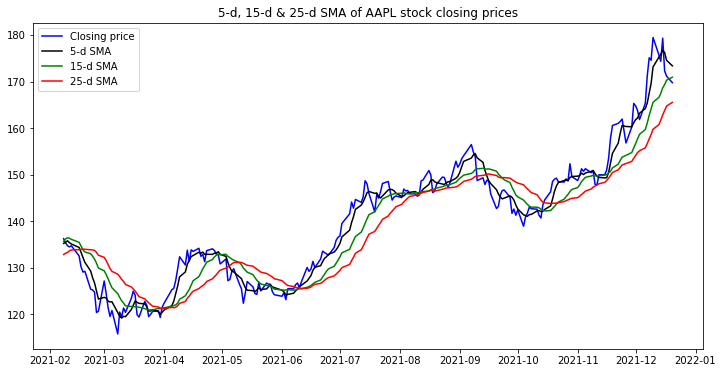

In [71]:
# Let's visualize the SMAs in a graph
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'], color='blue', label='Closing price')
plt.plot(df_apple['5d_sma_price'], color='black', label='5-d SMA')
plt.plot(df_apple['15d_sma_price'], color='green', label='15-d SMA')
plt.plot(df_apple['25d_sma_price'], color='red', label='25-d SMA')
plt.title("5-d, 15-d & 25-d SMA of AAPL stock closing prices")
plt.legend(loc='best')
plt.show()

# 3)- Creating buy/sell signals

## 3.1)- First strategy: 25-d SMA of price & trading volume



- After computing the 25-d SMAs, we need to establish a strategy based on which we generate a buy or sell signal. The strategy will be as simple as this: when the asset's close price is below the 25-d SMA, and the volume is above the 25-d SMA it's a buying signal, and vice versa for selling.

- Next, we'll create two columns indicating which days are having their 25-d SMA lower than the closing price, and their volume higher than 25-d SMA. We'll also add a variable **buy** that indicates our position in the previous day, so we can only buy if we sold the yesterday, and vice versa.

In [73]:
def first_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['Close'] <= row['25d_sma_price'] and row['Volume'] >= row['25d_sma_volume']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['Close'] > row['25d_sma_price'] and row['Volume'] < row['25d_sma_volume']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["sell_signals"], df_apple["buy_signals"] = first_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume,sell_signals,buy_signals
Date,,,,,,,,,,,,,
2021-02-08,135.398555,136.324246,134.293707,136.274475,71297200,0.0,0,135.246027,135.665580,132.870442,110034488.0,NaN,NaN
2021-02-09,135.985831,137.239992,135.219416,135.378662,76774200,0.0,0,135.489175,136.221039,133.140904,107373380.0,NaN,NaN
2021-02-10,135.846472,136.354115,133.776126,134.761536,73046600,0.0,0,135.817612,136.457071,133.323073,106388648.0,NaN,NaN
2021-02-11,135.269161,135.756892,133.149059,134.502747,64280000,0.0,0,135.408517,136.355163,133.670210,102756328.0,NaN,NaN
2021-02-12,133.726369,134.900884,133.069429,134.741623,60145100,0.0,0,135.131808,136.123409,133.855161,100779004.0,NaN,NaN


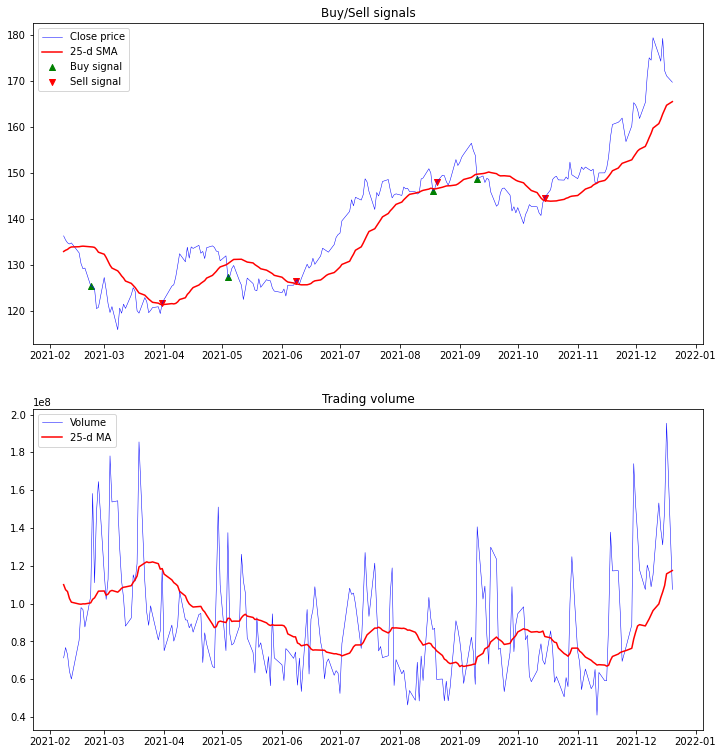

In [75]:
# Let's visualize buying/selling signals in the chart
fig, ax = plt.subplots(2, 1, figsize=(12, 13)) 
ax[0].plot(df_apple['Close'] , label='Close price', linewidth=0.5, color='blue')
ax[0].plot(df_apple['25d_sma_price'], color='red', label='25-d SMA')
ax[0].scatter(df_apple.index , df_apple['buy_signals'], label='Buy signal', marker='^', color='green')
ax[0].scatter(df_apple.index , df_apple['sell_signals'] , label='Sell signal' , marker='v', color='red')
ax[0].set_title("Buy/Sell signals")
ax[0].legend(loc='best')

ax[1].plot(df_apple['Volume'] , label='Volume', linewidth=0.5, color='blue')
ax[1].plot(df_apple['25d_sma_volume'], color='red', label='25-d MA')
ax[1].set_title("Trading volume")
ax[1].legend(loc='best')
plt.show()

## 3.2)- Second strategy: Short & long period SMA

- A second strategy would be to create a short period SMA (e.g: 10-d SMA), and a longer one (60-d SMA), and then analyze the crossovers between the two to generate buy/sell signals:

1.   If the short period SMA is below the long period SMA, it means that the trend is going down, so it's a **sell signal**, it's also known as **the death cross**.
2.   Otherwise, the trend is shiftting up, and it's a **buy signal**, it's also called **the golden cross**.





In [106]:
# Let's compute the 10-d, and 60-d SMA
df_apple = aapl.history(start="2021-1-1", end=datetime.today().strftime('%Y-%m-%d'), interval="1d")
df_apple["10d_sma_price"] = df_apple['Close'].rolling(10).mean()
df_apple["60d_sma_price"] = df_apple['Close'].rolling(60).mean()
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,10d_sma_price,60d_sma_price
Date,,,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0,NaN,NaN
2021-01-05,128.100300,130.932844,127.643112,130.207306,97664900,0.0,0,NaN,NaN
2021-01-06,126.937458,130.247057,125.605665,125.824318,155088000,0.0,0,NaN,NaN
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0,NaN,NaN
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0,NaN,NaN


In [107]:
def second_strategy(df):
    buy = False    
    buy_signals, sell_signals = [], []

    for key, row in df.iterrows():
        # Buying signal
        if row['10d_sma_price'] > row['60d_sma_price']:
            if buy:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(row['Close'])
                buy = True

        # Selling signal
        elif row['10d_sma_price'] < row['60d_sma_price']:
            if buy:
                sell_signals.append(row['Close'])
                buy_signals.append(np.nan)
                buy = False
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)

        # Neutral signal
        else:
            sell_signals.append(np.nan)
            buy_signals.append(np.nan)

    return sell_signals, buy_signals

df_apple["sell_signals"], df_apple["buy_signals"] = second_strategy(df_apple)
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,10d_sma_price,60d_sma_price,sell_signals,buy_signals
Date,,,,,,,,,,,
2021-01-04,132.701930,132.791375,125.983346,128.617111,143301900,0.0,0,NaN,NaN,NaN,NaN
2021-01-05,128.100300,130.932844,127.643112,130.207306,97664900,0.0,0,NaN,NaN,NaN,NaN
2021-01-06,126.937458,130.247057,125.605665,125.824318,155088000,0.0,0,NaN,NaN,NaN,NaN
2021-01-07,127.573546,130.823515,127.076610,130.117859,109578200,0.0,0,NaN,NaN,NaN,NaN
2021-01-08,131.618598,131.817384,129.432080,131.240936,105158200,0.0,0,NaN,NaN,NaN,NaN


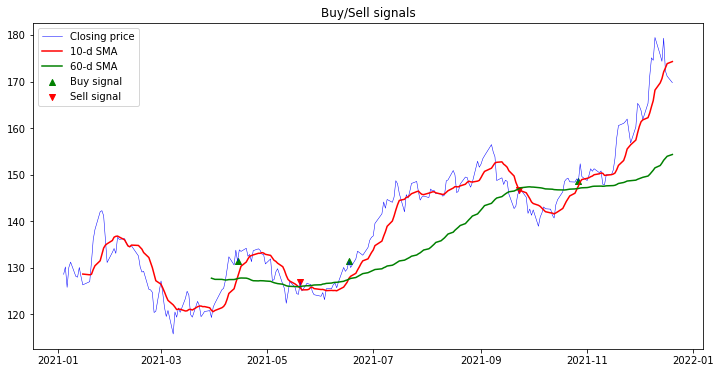

In [108]:
# Let's visualize buying/selling signals in the chart
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'] , label='Closing price', linewidth=0.5, color='blue')
plt.plot(df_apple['10d_sma_price'], color='red', label='10-d SMA')
plt.plot(df_apple['60d_sma_price'], color='green', label='60-d SMA')
plt.scatter(df_apple.index , df_apple['buy_signals'], label='Buy signal', marker='^', color='green')
plt.scatter(df_apple.index , df_apple['sell_signals'] , label='Sell signal' , marker='v', color='red')
plt.title("Buy/Sell signals")
plt.legend(loc='best')
plt.show()